# Approach 1: Transfer Learning Baseline for Multi-Label Aerial Image Classification

This notebook implements a baseline multi-label classification model using transfer learning with pre-trained CNNs.

## Strategy:
- Use pre-trained ResNet50/EfficientNet as feature extractor
- Replace final layer with multi-label classification head
- Train with Binary Cross-Entropy loss
- Evaluate with multi-label metrics (micro/macro F1, mAP)

## Expected Performance: 70-80% F1 score

## 1. Setup and Imports

In [ ]:
# Install required packages
!pip install torch torchvision transformers datasets pillow matplotlib scikit-learn tqdm

In [ ]:
pip install timm

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score, hamming_loss, classification_report
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA L4


## 2. Load and Explore Dataset

In [59]:
# Load dataset from HuggingFace
print("Loading AID_MultiLabel dataset...")
dataset = load_dataset("jonathan-roberts1/AID_MultiLabel")

print(f"\nDataset Info:")
print(f"Number of samples: {dataset['train'].num_rows}")
print(f"Features: {dataset['train'].features}")

# Extract class names
class_names = dataset['train'].features['label'].feature.names
num_classes = len(class_names)

print(f"\nNumber of classes: {num_classes}")
print(f"Class names: {class_names}")

Loading AID_MultiLabel dataset...

Dataset Info:
Number of samples: 3000
Features: {'image': Image(mode=None, decode=True), 'label': List(ClassLabel(names=['airplane', 'bare soil', 'buildings', 'cars', 'chaparral', 'court', 'dock', 'field', 'grass', 'mobile home', 'pavement', 'sand', 'sea', 'ship', 'tanks', 'trees', 'water']))}

Number of classes: 17
Class names: ['airplane', 'bare soil', 'buildings', 'cars', 'chaparral', 'court', 'dock', 'field', 'grass', 'mobile home', 'pavement', 'sand', 'sea', 'ship', 'tanks', 'trees', 'water']


In [60]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 3000
    })
})

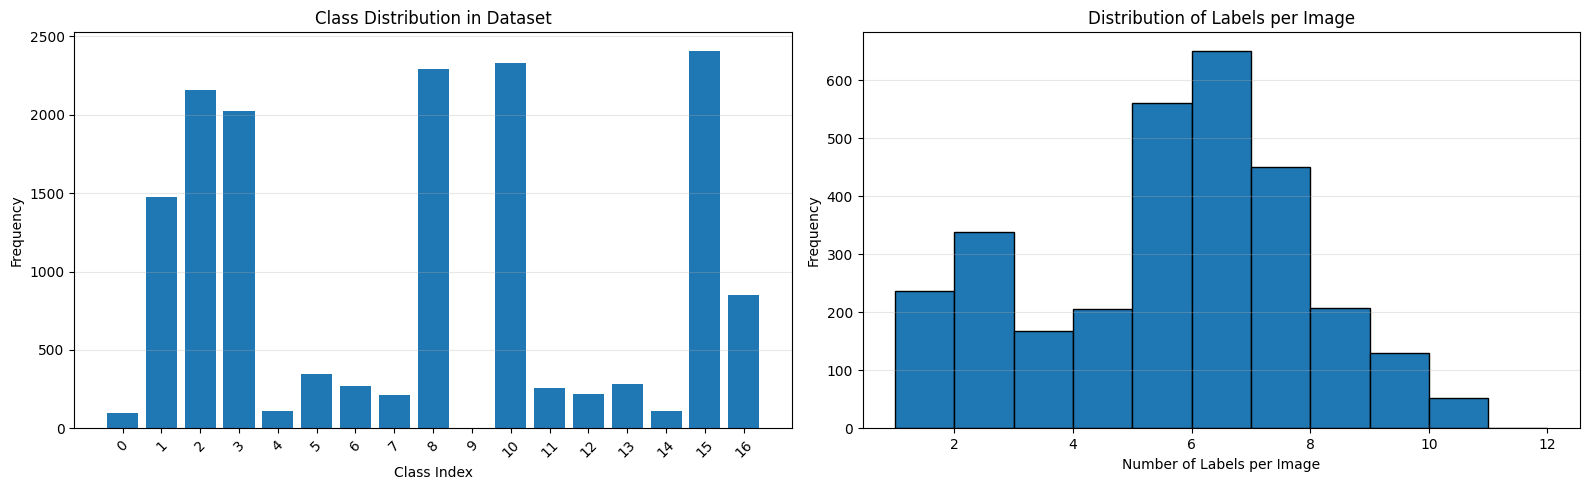


Dataset Statistics:
Average labels per image: 5.15
Min labels per image: 0
Max labels per image: 11

Most frequent classes:
  trees: 2406 (80.2%)
  pavement: 2328 (77.6%)
  grass: 2295 (76.5%)
  buildings: 2161 (72.0%)
  cars: 2026 (67.5%)

Least frequent classes:
  mobile home: 2 (0.1%)
  airplane: 99 (3.3%)
  tanks: 108 (3.6%)
  chaparral: 112 (3.7%)
  field: 214 (7.1%)


In [ ]:
# Analyze label distribution
all_labels = dataset['train']['label']

# Count occurrences of each class
class_counts = np.zeros(num_classes)
labels_per_image = []

for label_list in all_labels:
    labels_per_image.append(len(label_list))
    for cls_idx in label_list:
        class_counts[cls_idx] += 1

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Class frequency
axes[0].bar(range(num_classes), class_counts)
axes[0].set_xlabel('Class Index')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Class Distribution in Dataset')
axes[0].set_xticks(range(num_classes))
axes[0].set_xticklabels(range(num_classes), rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Labels per image
axes[1].hist(labels_per_image, bins=range(1, max(labels_per_image)+2), edgecolor='black')
axes[1].set_xlabel('Number of Labels per Image')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Labels per Image')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nDataset Statistics:")
print(f"Average labels per image: {np.mean(labels_per_image):.2f}")
print(f"Min labels per image: {np.min(labels_per_image)}")
print(f"Max labels per image: {np.max(labels_per_image)}")
print(f"\nMost frequent classes:")
for i in np.argsort(class_counts)[-5:][::-1]:
    print(f"  {class_names[i]}: {int(class_counts[i])} ({class_counts[i]/len(all_labels)*100:.1f}%)")
print(f"\nLeast frequent classes:")
for i in np.argsort(class_counts)[:5]:
    print(f"  {class_names[i]}: {int(class_counts[i])} ({class_counts[i]/len(all_labels)*100:.1f}%)")

## 3. Data Preprocessing and Augmentation

In [61]:
# Define image transformations
# Training: aggressive augmentation for aerial images (rotation-invariant)
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=90),  # Aerial images: any rotation is valid
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

# Validation/Test: no augmentation, only resize and normalize
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Transformations defined.")
print(f"Training transform: Aggressive augmentation with rotation, flips, color jitter")
print(f"Validation transform: Resize and normalize only")

Transformations defined.
Training transform: Aggressive augmentation with rotation, flips, color jitter
Validation transform: Resize and normalize only


In [62]:
# Custom Dataset class
class AIDMultiLabelDataset(Dataset):
    def __init__(self, images, labels, num_classes, transform=None):
        """
        Args:
            images: List of PIL images
            labels: List of label indices (multi-label)
            num_classes: Total number of classes
            transform: Torchvision transforms to apply
        """
        self.images = images
        self.labels = labels
        self.num_classes = num_classes
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get image
        image = self.images[idx]
        if not isinstance(image, Image.Image):
            image = Image.fromarray(image)

        # Convert to RGB if needed
        if image.mode != 'RGB':
            image = image.convert('RGB')

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        # Convert labels to multi-hot encoding
        label_vector = torch.zeros(self.num_classes, dtype=torch.float32)
        label_vector[self.labels[idx]] = 1.0

        return image, label_vector

print("Custom Dataset class defined.")

Custom Dataset class defined.


In [63]:
dataset['train'].shape

(3000, 2)

In [64]:
# Split dataset: 70% train, 15% validation, 15% test
images = list(dataset['train']['image'])
labels = list(dataset['train']['label'])

# First split: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    images, labels, test_size=0.3, random_state=42, shuffle=True
)

# Second split: split temp into 50-50 for val and test (15% each of total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True
)

print(f"Dataset split:")
print(f"  Training samples: {len(X_train)} ({len(X_train)/len(images)*100:.1f}%)")
print(f"  Validation samples: {len(X_val)} ({len(X_val)/len(images)*100:.1f}%)")
print(f"  Test samples: {len(X_test)} ({len(X_test)/len(images)*100:.1f}%)")

Dataset split:
  Training samples: 2100 (70.0%)
  Validation samples: 450 (15.0%)
  Test samples: 450 (15.0%)


In [65]:
print("Type of the X_train: ", type(X_train))
print("Type of the y_train: ", type(y_train))
print("Type of the X_val: ", type(X_val))
print("Type of the y_val: ", type(y_val))
print("Type of the X_test: ", type(X_test))
print("Type of the y_test: ", type(y_test))

Type of the X_train:  <class 'list'>
Type of the y_train:  <class 'list'>
Type of the X_val:  <class 'list'>
Type of the y_val:  <class 'list'>
Type of the X_test:  <class 'list'>
Type of the y_test:  <class 'list'>


In [66]:
# Create dataset objects
train_dataset = AIDMultiLabelDataset(X_train, y_train, num_classes, transform=train_transform)
val_dataset = AIDMultiLabelDataset(X_val, y_val, num_classes, transform=val_transform)
test_dataset = AIDMultiLabelDataset(X_test, y_test, num_classes, transform=val_transform)

print("\nDataset objects created successfully.")


Dataset objects created successfully.


In [68]:
from torch.utils.data import WeightedRandomSampler

# Define BATCH_SIZE here, as it's used by the train_loader below
BATCH_SIZE = 32

def get_sample_weights(labels_list_of_lists, num_classes):
    """
    Calculate sampling weights based on label rarity.
    Images with rare labels get sampled more often.
    """
    # 1. Convert labels_list_of_lists to multi-hot encoded numpy array
    labels_multihot = np.zeros((len(labels_list_of_lists), num_classes), dtype=np.float32)
    for i, label_indices in enumerate(labels_list_of_lists):
        if label_indices: # Ensure the list of labels for an image is not empty
            labels_multihot[i, label_indices] = 1.0

    # Calculate pos_counts (frequency of each class across all samples)
    pos_counts = labels_multihot.sum(axis=0)

    # Calculate inverse frequency for label weights. Add a small constant to prevent division by zero.
    label_weights = 1.0 / (pos_counts + 1e-6) # Use a very small epsilon

    sample_weights = []
    for label_indices_for_image in labels_list_of_lists:
        if label_indices_for_image:
            # The weight for an image is the average of the weights of its positive labels
            weight = np.mean([label_weights[idx] for idx in label_indices_for_image])
        else:
            # If an image has no labels, assign a neutral weight (e.g., 1.0)
            weight = 1.0
        sample_weights.append(weight)

    return torch.DoubleTensor(sample_weights)

# Create weighted sampler
sample_weights = get_sample_weights(y_train, num_classes)
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# Use in DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,  # Instead of shuffle=True
    num_workers=2
)

In [70]:
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"Data loaders created:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Train batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

Data loaders created:
  Batch size: 32
  Train batches: 66
  Validation batches: 15
  Test batches: 15


## 4. Model Architecture

In [ ]:
class MultiLabelCNN(nn.Module):
    """
    Multi-label classification model using pre-trained CNN backbone.
    """
    def __init__(self, num_classes, backbone='resnet50', pretrained=True, dropout=0.5):
        super(MultiLabelCNN, self).__init__()

        self.num_classes = num_classes
        self.backbone_name = backbone

        # Load pre-trained backbone
        if backbone == 'resnet50':
            self.backbone = models.resnet50(pretrained=pretrained)
            num_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()  # Remove original FC layer

        elif backbone == 'resnet34':
            self.backbone = models.resnet34(pretrained=pretrained)
            num_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()

        elif backbone == 'resnet101':
            self.backbone = models.resnet101(pretrained=pretrained)
            num_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()

        else:
            raise ValueError(f"Unsupported backbone: {backbone}")

        # Multi-label classification head
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, num_classes)
        )

        print(f"Model initialized:")
        print(f"  Backbone: {backbone} (pretrained={pretrained})")
        print(f"  Feature dimension: {num_features}")
        print(f"  Output classes: {num_classes}")
        print(f"  Dropout: {dropout}")

    def forward(self, x):
        # Extract features
        features = self.backbone(x)

        # Classify
        logits = self.classifier(features)

        return logits

    def get_num_params(self):
        return sum(p.numel() for p in self.parameters())

    def get_num_trainable_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

print("Model class defined.")

Model class defined.


In [71]:
import timm  # pip install timm

class MultiLabelEfficientNet(nn.Module):
    def __init__(self, num_classes, model_name='efficientnet_b3', pretrained=True, dropout=0.5):
        super().__init__()

        # Load EfficientNet from timm
        self.backbone = timm.create_model(
            model_name,
            pretrained=pretrained,
            num_classes=0,  # Remove classification head
            global_pool=''  # Remove global pooling
        )

        # Get feature dimension
        num_features = self.backbone.num_features

        # Custom head
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # Extract features
        features = self.backbone(x)
        features = self.global_pool(features)
        features = features.flatten(1)

        # Classify
        logits = self.classifier(features)
        return logits

In [72]:
# Initialize model
# MODEL_BACKBONE = 'resnet50'  # Options: 'resnet34', 'resnet50', 'resnet101'
DROPOUT_RATE = 0.25

"""model = MultiLabelCNN(
    num_classes=num_classes,
    backbone=MODEL_BACKBONE,
    pretrained=True,
    dropout=DROPOUT_RATE
)"""
MODEL_BACKBONE = 'efficientnet_b4'

model = MultiLabelEfficientNet(
    num_classes=17,
    model_name=MODEL_BACKBONE,  # or 'efficientnet_b4'
    pretrained=True,
    dropout=DROPOUT_RATE
)

model = model.to(device)

"""print(f"\nModel moved to {device}")
print(f"Total parameters: {model.get_num_params():,}")
print(f"Trainable parameters: {model.get_num_trainable_params():,}")"""

'print(f"\nModel moved to {device}")\nprint(f"Total parameters: {model.get_num_params():,}")\nprint(f"Trainable parameters: {model.get_num_trainable_params():,}")'

## 5. Loss Function and Optimizer

In [73]:
# Binary Cross-Entropy Loss (suitable for multi-label)
# BCEWithLogitsLoss combines sigmoid + BCE for numerical stability
criterion = nn.BCEWithLogitsLoss()

print("Loss function: BCEWithLogitsLoss")
print("  - Combines Sigmoid + BCE for numerical stability")
print("  - Suitable for multi-label classification")
print("  - Treats each label independently")

Loss function: BCEWithLogitsLoss
  - Combines Sigmoid + BCE for numerical stability
  - Suitable for multi-label classification
  - Treats each label independently


In [74]:
# Optimizer and Learning Rate Scheduler
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-4

optimizer = optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

# Learning rate scheduler: reduce LR when validation loss plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3
)

print(f"\nOptimizer: Adam")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Weight decay: {WEIGHT_DECAY}")
print(f"\nScheduler: ReduceLROnPlateau")
print(f"  Factor: 0.5")
print(f"  Patience: 3 epochs")


Optimizer: Adam
  Learning rate: 0.001
  Weight decay: 0.0001

Scheduler: ReduceLROnPlateau
  Factor: 0.5
  Patience: 3 epochs


## 6. Training and Evaluation Functions

In [75]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    """
    Train model for one epoch.
    """
    model.train()
    running_loss = 0.0

    progress_bar = tqdm(dataloader, desc='Training')

    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})

    epoch_loss = running_loss / len(dataloader)
    return epoch_loss

In [ ]:
def evaluate(model, dataloader, criterion, device, threshold=0.5):
    """
    Evaluate model on validation/test set.
    """
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Evaluating'):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            # Get probabilities and predictions
            probs = torch.sigmoid(outputs)  # Convert logits to probabilities
            preds = (probs > threshold).float()  # Apply threshold

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader)
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    return epoch_loss, all_preds, all_labels, all_probs

In [ ]:
def calculate_metrics(y_true, y_pred, class_names):
    """
    Calculate comprehensive multi-label classification metrics.
    """
    # Overall metrics
    micro_f1 = f1_score(y_true, y_pred, average='micro', zero_division=0)
    macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    weighted_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    micro_precision = precision_score(y_true, y_pred, average='micro', zero_division=0)
    macro_precision = precision_score(y_true, y_pred, average='macro', zero_division=0)

    micro_recall = recall_score(y_true, y_pred, average='micro', zero_division=0)
    macro_recall = recall_score(y_true, y_pred, average='macro', zero_division=0)

    hamming = hamming_loss(y_true, y_pred)

    # Per-class metrics
    per_class_f1 = f1_score(y_true, y_pred, average=None, zero_division=0)
    per_class_precision = precision_score(y_true, y_pred, average=None, zero_division=0)
    per_class_recall = recall_score(y_true, y_pred, average=None, zero_division=0)

    # Subset accuracy (exact match)
    subset_acc = np.mean(np.all(y_true == y_pred, axis=1))

    metrics = {
        'micro_f1': micro_f1,
        'macro_f1': macro_f1,
        'weighted_f1': weighted_f1,
        'micro_precision': micro_precision,
        'macro_precision': macro_precision,
        'micro_recall': micro_recall,
        'macro_recall': macro_recall,
        'hamming_loss': hamming,
        'subset_accuracy': subset_acc,
        'per_class_f1': per_class_f1,
        'per_class_precision': per_class_precision,
        'per_class_recall': per_class_recall
    }

    return metrics

def print_metrics(metrics):
    """
    Pretty print metrics.
    """
    print("\n" + "="*60)
    print("EVALUATION METRICS")
    print("="*60)
    print(f"\nOverall Performance:")
    print(f"  Micro F1:      {metrics['micro_f1']:.4f}")
    print(f"  Macro F1:      {metrics['macro_f1']:.4f}")
    print(f"  Weighted F1:   {metrics['weighted_f1']:.4f}")
    print(f"\n  Micro Precision: {metrics['micro_precision']:.4f}")
    print(f"  Macro Precision: {metrics['macro_precision']:.4f}")
    print(f"\n  Micro Recall:    {metrics['micro_recall']:.4f}")
    print(f"  Macro Recall:    {metrics['macro_recall']:.4f}")
    print(f"\n  Hamming Loss:    {metrics['hamming_loss']:.4f}")
    print(f"  Subset Accuracy: {metrics['subset_accuracy']:.4f}")
    print("="*60)

print("Training and evaluation functions defined.")

Training and evaluation functions defined.


## 7. Training Loop

In [76]:
# Training configuration
NUM_EPOCHS = 30
EARLY_STOP_PATIENCE = 7

# For tracking
history = {
    'train_loss': [],
    'val_loss': [],
    'val_micro_f1': [],
    'val_macro_f1': [],
}

best_val_f1 = 0.0
best_model_path = 'best_model_baseline.pth'
epochs_no_improve = 0

print(f"Starting training for {NUM_EPOCHS} epochs...")
print(f"Early stopping patience: {EARLY_STOP_PATIENCE}")
print(f"Best model will be saved to: {best_model_path}\n")

Starting training for 30 epochs...
Early stopping patience: 7
Best model will be saved to: best_model_baseline.pth



In [77]:
# Main training loop
for epoch in range(NUM_EPOCHS):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"{'='*60}")

    # Train
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_preds, val_labels, val_probs = evaluate(
        model, val_loader, criterion, device, threshold=0.5
    )

    # Calculate metrics
    val_metrics = calculate_metrics(val_labels, val_preds, class_names)

    # Store history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_micro_f1'].append(val_metrics['micro_f1'])
    history['val_macro_f1'].append(val_metrics['macro_f1'])

    # Print epoch summary
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss:   {val_loss:.4f}")
    print(f"  Val Micro F1: {val_metrics['micro_f1']:.4f}")
    print(f"  Val Macro F1: {val_metrics['macro_f1']:.4f}")

    # Learning rate scheduling
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"  Current LR: {current_lr:.6f}")

    # Save best model
    if val_metrics['macro_f1'] > best_val_f1:
        best_val_f1 = val_metrics['macro_f1']
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_f1': best_val_f1,
            'metrics': val_metrics
        }, best_model_path)
        print(f"  ✓ New best model saved! (Macro F1: {best_val_f1:.4f})")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"  No improvement for {epochs_no_improve} epoch(s)")

    # Early stopping
    if epochs_no_improve >= EARLY_STOP_PATIENCE:
        print(f"\nEarly stopping triggered after {epoch+1} epochs.")
        break

print(f"\n{'='*60}")
print("Training completed!")
print(f"Best validation Macro F1: {best_val_f1:.4f}")
print(f"{'='*60}")


Epoch 1/30


Evaluating: 100%|██████████| 15/15 [00:01<00:00, 10.89it/s]



Epoch 1 Summary:
  Train Loss: 0.3217
  Val Loss:   0.2034
  Val Micro F1: 0.8566
  Val Macro F1: 0.5023
  Current LR: 0.001000
  ✓ New best model saved! (Macro F1: 0.5023)

Epoch 2/30


Evaluating: 100%|██████████| 15/15 [00:01<00:00, 10.93it/s]



Epoch 2 Summary:
  Train Loss: 0.1955
  Val Loss:   0.1629
  Val Micro F1: 0.8958
  Val Macro F1: 0.7113
  Current LR: 0.001000
  ✓ New best model saved! (Macro F1: 0.7113)

Epoch 3/30


Evaluating: 100%|██████████| 15/15 [00:01<00:00, 10.96it/s]



Epoch 3 Summary:
  Train Loss: 0.1586
  Val Loss:   0.1429
  Val Micro F1: 0.9071
  Val Macro F1: 0.7591
  Current LR: 0.001000
  ✓ New best model saved! (Macro F1: 0.7591)

Epoch 4/30


Evaluating: 100%|██████████| 15/15 [00:01<00:00, 10.96it/s]



Epoch 4 Summary:
  Train Loss: 0.1505
  Val Loss:   0.1415
  Val Micro F1: 0.9096
  Val Macro F1: 0.7559
  Current LR: 0.001000
  No improvement for 1 epoch(s)

Epoch 5/30


Evaluating: 100%|██████████| 15/15 [00:01<00:00, 10.82it/s]



Epoch 5 Summary:
  Train Loss: 0.1403
  Val Loss:   0.1443
  Val Micro F1: 0.9077
  Val Macro F1: 0.7451
  Current LR: 0.001000
  No improvement for 2 epoch(s)

Epoch 6/30


Evaluating: 100%|██████████| 15/15 [00:01<00:00, 10.98it/s]



Epoch 6 Summary:
  Train Loss: 0.1366
  Val Loss:   0.1532
  Val Micro F1: 0.9018
  Val Macro F1: 0.7363
  Current LR: 0.001000
  No improvement for 3 epoch(s)

Epoch 7/30


Evaluating: 100%|██████████| 15/15 [00:01<00:00, 10.96it/s]



Epoch 7 Summary:
  Train Loss: 0.1336
  Val Loss:   0.1498
  Val Micro F1: 0.9030
  Val Macro F1: 0.7346
  Current LR: 0.001000
  No improvement for 4 epoch(s)

Epoch 8/30


Evaluating: 100%|██████████| 15/15 [00:01<00:00, 10.96it/s]



Epoch 8 Summary:
  Train Loss: 0.1413
  Val Loss:   0.1460
  Val Micro F1: 0.9095
  Val Macro F1: 0.7644
  Current LR: 0.000500
  ✓ New best model saved! (Macro F1: 0.7644)

Epoch 9/30


Evaluating: 100%|██████████| 15/15 [00:01<00:00, 10.85it/s]



Epoch 9 Summary:
  Train Loss: 0.1195
  Val Loss:   0.1331
  Val Micro F1: 0.9087
  Val Macro F1: 0.7619
  Current LR: 0.000500
  No improvement for 1 epoch(s)

Epoch 10/30


Evaluating: 100%|██████████| 15/15 [00:01<00:00, 10.85it/s]



Epoch 10 Summary:
  Train Loss: 0.1073
  Val Loss:   0.1275
  Val Micro F1: 0.9127
  Val Macro F1: 0.7710
  Current LR: 0.000500
  ✓ New best model saved! (Macro F1: 0.7710)

Epoch 11/30


Evaluating: 100%|██████████| 15/15 [00:01<00:00, 10.99it/s]



Epoch 11 Summary:
  Train Loss: 0.1013
  Val Loss:   0.1357
  Val Micro F1: 0.9106
  Val Macro F1: 0.7600
  Current LR: 0.000500
  No improvement for 1 epoch(s)

Epoch 12/30


Evaluating: 100%|██████████| 15/15 [00:01<00:00, 10.99it/s]



Epoch 12 Summary:
  Train Loss: 0.1006
  Val Loss:   0.1361
  Val Micro F1: 0.9103
  Val Macro F1: 0.7794
  Current LR: 0.000500
  ✓ New best model saved! (Macro F1: 0.7794)

Epoch 13/30


Evaluating: 100%|██████████| 15/15 [00:01<00:00, 10.79it/s]



Epoch 13 Summary:
  Train Loss: 0.0983
  Val Loss:   0.1426
  Val Micro F1: 0.9111
  Val Macro F1: 0.7762
  Current LR: 0.000500
  No improvement for 1 epoch(s)

Epoch 14/30


Evaluating: 100%|██████████| 15/15 [00:01<00:00, 10.81it/s]



Epoch 14 Summary:
  Train Loss: 0.0999
  Val Loss:   0.1435
  Val Micro F1: 0.9029
  Val Macro F1: 0.7599
  Current LR: 0.000250
  No improvement for 2 epoch(s)

Epoch 15/30


Evaluating: 100%|██████████| 15/15 [00:01<00:00, 10.88it/s]



Epoch 15 Summary:
  Train Loss: 0.0846
  Val Loss:   0.1378
  Val Micro F1: 0.9099
  Val Macro F1: 0.7748
  Current LR: 0.000250
  No improvement for 3 epoch(s)

Epoch 16/30


Evaluating: 100%|██████████| 15/15 [00:01<00:00, 10.98it/s]



Epoch 16 Summary:
  Train Loss: 0.0733
  Val Loss:   0.1520
  Val Micro F1: 0.9102
  Val Macro F1: 0.7848
  Current LR: 0.000250
  ✓ New best model saved! (Macro F1: 0.7848)

Epoch 17/30


Evaluating: 100%|██████████| 15/15 [00:01<00:00, 10.81it/s]



Epoch 17 Summary:
  Train Loss: 0.0681
  Val Loss:   0.1451
  Val Micro F1: 0.9107
  Val Macro F1: 0.7948
  Current LR: 0.000250
  ✓ New best model saved! (Macro F1: 0.7948)

Epoch 18/30


Evaluating: 100%|██████████| 15/15 [00:01<00:00, 10.90it/s]



Epoch 18 Summary:
  Train Loss: 0.0656
  Val Loss:   0.1604
  Val Micro F1: 0.9091
  Val Macro F1: 0.7791
  Current LR: 0.000125
  No improvement for 1 epoch(s)

Epoch 19/30


Evaluating: 100%|██████████| 15/15 [00:01<00:00, 10.92it/s]



Epoch 19 Summary:
  Train Loss: 0.0544
  Val Loss:   0.1592
  Val Micro F1: 0.9146
  Val Macro F1: 0.7948
  Current LR: 0.000125
  ✓ New best model saved! (Macro F1: 0.7948)

Epoch 20/30


Evaluating: 100%|██████████| 15/15 [00:01<00:00, 10.92it/s]



Epoch 20 Summary:
  Train Loss: 0.0491
  Val Loss:   0.1657
  Val Micro F1: 0.9133
  Val Macro F1: 0.7912
  Current LR: 0.000125
  No improvement for 1 epoch(s)

Epoch 21/30


Evaluating: 100%|██████████| 15/15 [00:01<00:00, 10.95it/s]



Epoch 21 Summary:
  Train Loss: 0.0454
  Val Loss:   0.1638
  Val Micro F1: 0.9128
  Val Macro F1: 0.8009
  Current LR: 0.000125
  ✓ New best model saved! (Macro F1: 0.8009)

Epoch 22/30


Evaluating: 100%|██████████| 15/15 [00:01<00:00, 10.98it/s]



Epoch 22 Summary:
  Train Loss: 0.0446
  Val Loss:   0.1697
  Val Micro F1: 0.9152
  Val Macro F1: 0.7933
  Current LR: 0.000063
  No improvement for 1 epoch(s)

Epoch 23/30


Evaluating: 100%|██████████| 15/15 [00:01<00:00, 10.71it/s]



Epoch 23 Summary:
  Train Loss: 0.0380
  Val Loss:   0.1722
  Val Micro F1: 0.9170
  Val Macro F1: 0.8074
  Current LR: 0.000063
  ✓ New best model saved! (Macro F1: 0.8074)

Epoch 24/30


Evaluating: 100%|██████████| 15/15 [00:01<00:00, 11.00it/s]



Epoch 24 Summary:
  Train Loss: 0.0324
  Val Loss:   0.1774
  Val Micro F1: 0.9115
  Val Macro F1: 0.7921
  Current LR: 0.000063
  No improvement for 1 epoch(s)

Epoch 25/30


Evaluating: 100%|██████████| 15/15 [00:01<00:00, 10.95it/s]



Epoch 25 Summary:
  Train Loss: 0.0322
  Val Loss:   0.1793
  Val Micro F1: 0.9123
  Val Macro F1: 0.7911
  Current LR: 0.000063
  No improvement for 2 epoch(s)

Epoch 26/30


Evaluating: 100%|██████████| 15/15 [00:01<00:00, 10.89it/s]



Epoch 26 Summary:
  Train Loss: 0.0310
  Val Loss:   0.1912
  Val Micro F1: 0.9122
  Val Macro F1: 0.8006
  Current LR: 0.000031
  No improvement for 3 epoch(s)

Epoch 27/30


Evaluating: 100%|██████████| 15/15 [00:01<00:00, 10.67it/s]



Epoch 27 Summary:
  Train Loss: 0.0259
  Val Loss:   0.1953
  Val Micro F1: 0.9110
  Val Macro F1: 0.7999
  Current LR: 0.000031
  No improvement for 4 epoch(s)

Epoch 28/30


Evaluating: 100%|██████████| 15/15 [00:01<00:00, 10.82it/s]



Epoch 28 Summary:
  Train Loss: 0.0253
  Val Loss:   0.2016
  Val Micro F1: 0.9110
  Val Macro F1: 0.7863
  Current LR: 0.000031
  No improvement for 5 epoch(s)

Epoch 29/30


Evaluating: 100%|██████████| 15/15 [00:01<00:00, 10.85it/s]



Epoch 29 Summary:
  Train Loss: 0.0259
  Val Loss:   0.2023
  Val Micro F1: 0.9113
  Val Macro F1: 0.7930
  Current LR: 0.000031
  No improvement for 6 epoch(s)

Epoch 30/30


Evaluating: 100%|██████████| 15/15 [00:01<00:00, 10.82it/s]


Epoch 30 Summary:
  Train Loss: 0.0226
  Val Loss:   0.2076
  Val Micro F1: 0.9121
  Val Macro F1: 0.7980
  Current LR: 0.000016
  No improvement for 7 epoch(s)

Early stopping triggered after 30 epochs.

Training completed!
Best validation Macro F1: 0.8074


## 8. Visualize Training Progress

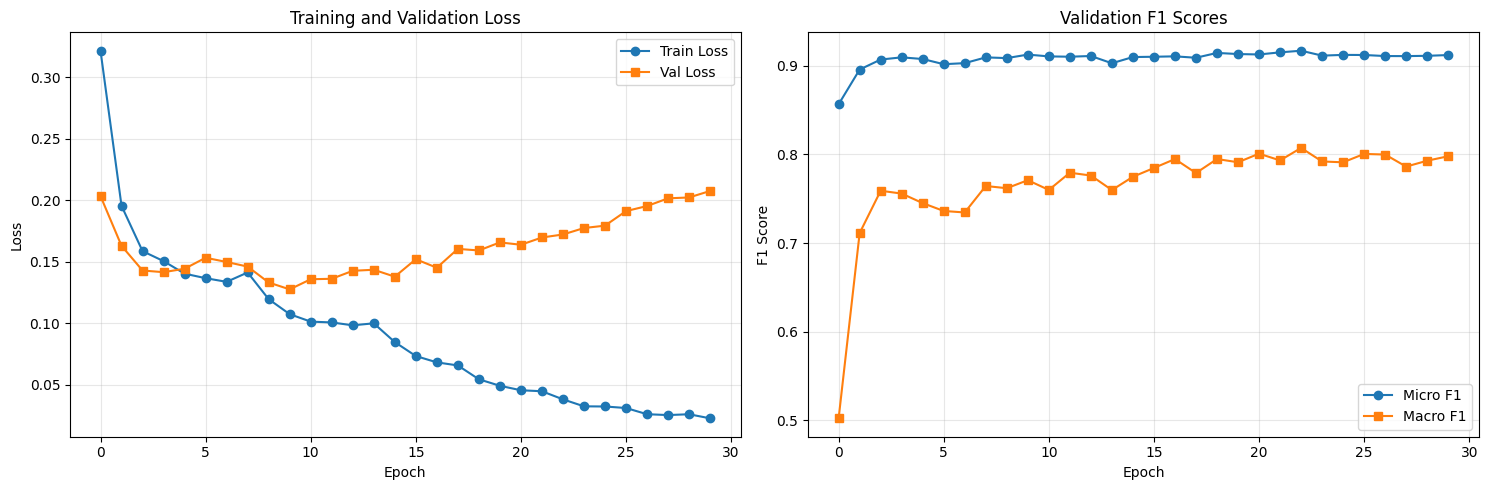

Training history visualized and saved to 'training_history.png'


In [78]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# F1 scores
axes[1].plot(history['val_micro_f1'], label='Micro F1', marker='o')
axes[1].plot(history['val_macro_f1'], label='Macro F1', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('F1 Score')
axes[1].set_title('Validation F1 Scores')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("Training history visualized and saved to 'training_history.png'")

## 9. Test Set Evaluation

In [80]:
# Load best model
print("Loading best model for testing...")
checkpoint = torch.load(best_model_path, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Best model from epoch {checkpoint['epoch']+1} loaded.\n")

# Evaluate on test set
test_loss, test_preds, test_labels, test_probs = evaluate(
    model, test_loader, criterion, device, threshold=0.5
)

# Calculate metrics
test_metrics = calculate_metrics(test_labels, test_preds, class_names)

# Print results
print_metrics(test_metrics)

Loading best model for testing...
Best model from epoch 23 loaded.



Evaluating: 100%|██████████| 15/15 [00:01<00:00, 10.79it/s]


EVALUATION METRICS

Overall Performance:
  Micro F1:      0.9165
  Macro F1:      0.8097
  Weighted F1:   0.9165

  Micro Precision: 0.9039
  Macro Precision: 0.8108

  Micro Recall:    0.9293
  Macro Recall:    0.8114

  Hamming Loss:    0.0505
  Subset Accuracy: 0.4667


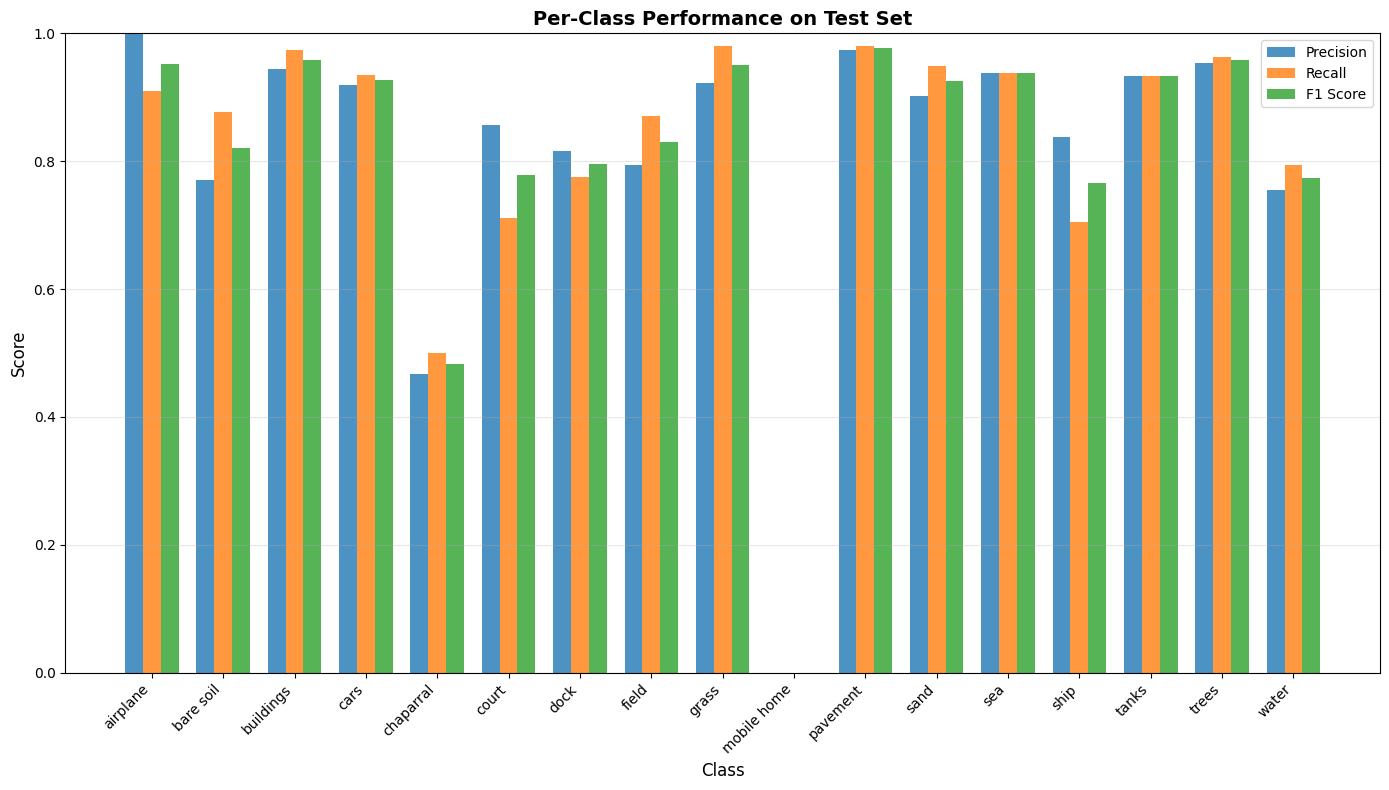

Per-class performance visualized and saved to 'per_class_performance.png'


In [81]:
# Per-class performance visualization
per_class_data = {
    'Class': class_names,
    'F1': test_metrics['per_class_f1'],
    'Precision': test_metrics['per_class_precision'],
    'Recall': test_metrics['per_class_recall']
}

fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(class_names))
width = 0.25

ax.bar(x - width, per_class_data['Precision'], width, label='Precision', alpha=0.8)
ax.bar(x, per_class_data['Recall'], width, label='Recall', alpha=0.8)
ax.bar(x + width, per_class_data['F1'], width, label='F1 Score', alpha=0.8)

ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Per-Class Performance on Test Set', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.0])

plt.tight_layout()
plt.savefig('per_class_performance.png', dpi=150, bbox_inches='tight')
plt.show()

print("Per-class performance visualized and saved to 'per_class_performance.png'")

In [82]:
# Detailed per-class results table
print("\nDetailed Per-Class Results:")
print("="*80)
print(f"{'Class':<20} {'Precision':>12} {'Recall':>12} {'F1 Score':>12} {'Support':>10}")
print("="*80)

for i, class_name in enumerate(class_names):
    support = int(test_labels[:, i].sum())
    print(f"{class_name:<20} {test_metrics['per_class_precision'][i]:>12.4f} "
          f"{test_metrics['per_class_recall'][i]:>12.4f} "
          f"{test_metrics['per_class_f1'][i]:>12.4f} {support:>10}")

print("="*80)

# Identify best and worst performing classes
best_idx = np.argmax(test_metrics['per_class_f1'])
worst_idx = np.argmin(test_metrics['per_class_f1'])

print(f"\nBest performing class: {class_names[best_idx]} (F1: {test_metrics['per_class_f1'][best_idx]:.4f})")
print(f"Worst performing class: {class_names[worst_idx]} (F1: {test_metrics['per_class_f1'][worst_idx]:.4f})")


Detailed Per-Class Results:
Class                   Precision       Recall     F1 Score    Support
airplane                   1.0000       0.9091       0.9524         11
bare soil                  0.7711       0.8767       0.8205        219
buildings                  0.9441       0.9744       0.9590        312
cars                       0.9191       0.9342       0.9266        304
chaparral                  0.4667       0.5000       0.4828         14
court                      0.8571       0.7119       0.7778         59
dock                       0.8158       0.7750       0.7949         40
field                      0.7941       0.8710       0.8308         31
grass                      0.9227       0.9795       0.9502        341
mobile home                0.0000       0.0000       0.0000          0
pavement                   0.9743       0.9799       0.9771        348
sand                       0.9024       0.9487       0.9250         39
sea                        0.9375       0.9375  

## 10. Prediction Visualization

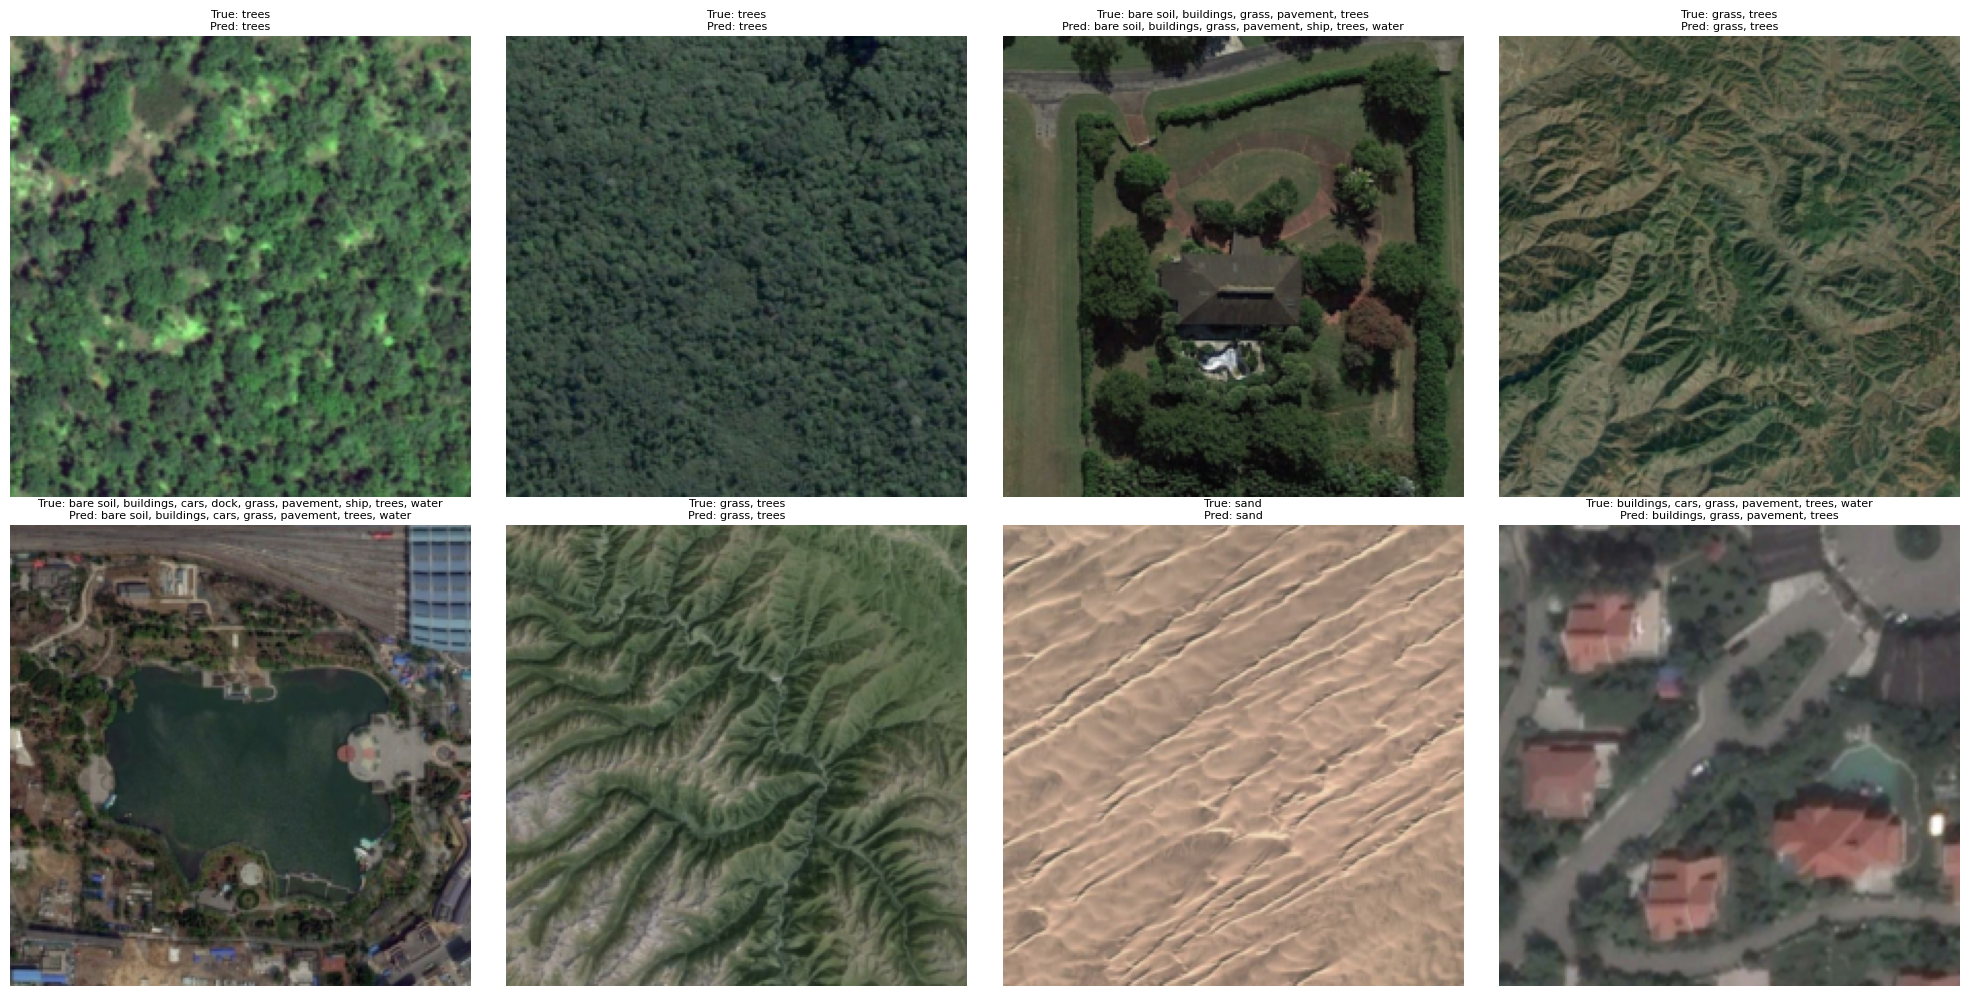

Prediction samples visualized and saved to 'prediction_samples.png'
Green border = Correct prediction, Red border = Incorrect prediction


In [83]:
def visualize_predictions(model, dataset, device, num_samples=8, threshold=0.5):
    """
    Visualize model predictions on sample images.
    """
    model.eval()

    # Randomly select samples
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()

    for idx, ax in zip(indices, axes):
        image, label = dataset[idx]

        # Predict
        with torch.no_grad():
            image_input = image.unsqueeze(0).to(device)
            output = model(image_input)
            probs = torch.sigmoid(output).cpu().numpy()[0]
            pred = (probs > threshold).astype(int)

        # Convert image for display
        img_display = image.cpu().numpy().transpose(1, 2, 0)
        # Denormalize
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_display = std * img_display + mean
        img_display = np.clip(img_display, 0, 1)

        # Get labels
        true_labels = [class_names[i] for i in range(num_classes) if label[i] == 1]
        pred_labels = [class_names[i] for i in range(num_classes) if pred[i] == 1]

        # Display
        ax.imshow(img_display)
        ax.axis('off')

        title = f"True: {', '.join(true_labels)}\nPred: {', '.join(pred_labels)}"
        ax.set_title(title, fontsize=8, wrap=True)

        # Add colored border (green=correct, red=incorrect)
        if set(true_labels) == set(pred_labels):
            for spine in ax.spines.values():
                spine.set_edgecolor('green')
                spine.set_linewidth(3)
        else:
            for spine in ax.spines.values():
                spine.set_edgecolor('red')
                spine.set_linewidth(3)

    plt.tight_layout()
    plt.savefig('prediction_samples.png', dpi=150, bbox_inches='tight')
    plt.show()

# Visualize predictions
visualize_predictions(model, test_dataset, device, num_samples=8, threshold=0.5)
print("Prediction samples visualized and saved to 'prediction_samples.png'")
print("Green border = Correct prediction, Red border = Incorrect prediction")

## 11. Threshold Optimization (Optional)

Searching for optimal threshold...



Evaluating: 100%|██████████| 15/15 [00:01<00:00, 10.71it/s]


Optimal threshold: 0.65
Micro F1 at optimal threshold: 0.9187
Micro F1 at default threshold (0.5): 0.9170
Improvement: 0.0017


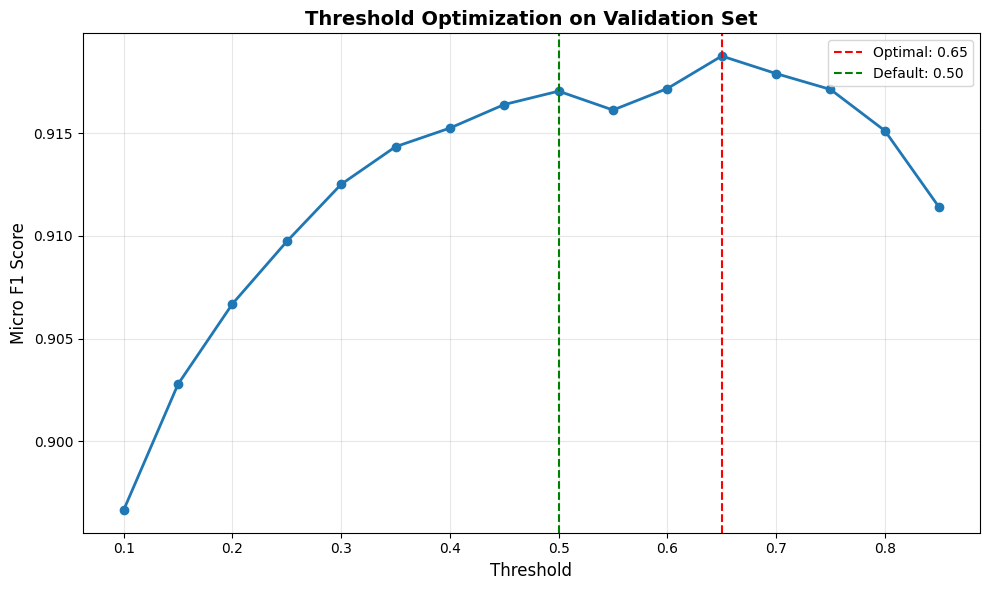

In [84]:
# Find optimal threshold on validation set
print("Searching for optimal threshold...\n")

# Get validation predictions (already computed)
_, val_preds_default, val_labels, val_probs = evaluate(
    model, val_loader, criterion, device, threshold=0.5
)

# Try different thresholds
thresholds = np.arange(0.1, 0.9, 0.05)
f1_scores = []

for thresh in thresholds:
    preds = (val_probs > thresh).astype(int)
    f1 = f1_score(val_labels, preds, average='micro')
    f1_scores.append(f1)

# Find best threshold
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f"Optimal threshold: {best_threshold:.2f}")
print(f"Micro F1 at optimal threshold: {best_f1:.4f}")
print(f"Micro F1 at default threshold (0.5): {f1_scores[8]:.4f}")
print(f"Improvement: {best_f1 - f1_scores[8]:.4f}")

# Plot threshold analysis
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, marker='o', linewidth=2)
plt.axvline(best_threshold, color='r', linestyle='--', label=f'Optimal: {best_threshold:.2f}')
plt.axvline(0.5, color='g', linestyle='--', label='Default: 0.50')
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Micro F1 Score', fontsize=12)
plt.title('Threshold Optimization on Validation Set', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('threshold_optimization.png', dpi=150, bbox_inches='tight')
plt.show()

In [85]:
# Re-evaluate on test set with optimal threshold
print(f"\nRe-evaluating on test set with optimal threshold ({best_threshold:.2f})...\n")

test_preds_optimized = (test_probs > best_threshold).astype(int)
test_metrics_optimized = calculate_metrics(test_labels, test_preds_optimized, class_names)

print("\nComparison: Default (0.5) vs Optimized Threshold")
print("="*70)
print(f"{'Metric':<25} {'Default (0.5)':>20} {'Optimized':>20}")
print("="*70)
print(f"{'Micro F1':<25} {test_metrics['micro_f1']:>20.4f} {test_metrics_optimized['micro_f1']:>20.4f}")
print(f"{'Macro F1':<25} {test_metrics['macro_f1']:>20.4f} {test_metrics_optimized['macro_f1']:>20.4f}")
print(f"{'Micro Precision':<25} {test_metrics['micro_precision']:>20.4f} {test_metrics_optimized['micro_precision']:>20.4f}")
print(f"{'Micro Recall':<25} {test_metrics['micro_recall']:>20.4f} {test_metrics_optimized['micro_recall']:>20.4f}")
print(f"{'Hamming Loss':<25} {test_metrics['hamming_loss']:>20.4f} {test_metrics_optimized['hamming_loss']:>20.4f}")
print("="*70)


Re-evaluating on test set with optimal threshold (0.65)...


Comparison: Default (0.5) vs Optimized Threshold
Metric                           Default (0.5)            Optimized
Micro F1                                0.9165               0.9162
Macro F1                                0.8097               0.7989
Micro Precision                         0.9039               0.9177
Micro Recall                            0.9293               0.9148
Hamming Loss                            0.0505               0.0498


## 12. Summary and Next Steps

In [89]:
print("\n" + "="*70)
print("BASELINE MODEL SUMMARY")
print("="*70)
print(f"\nModel Architecture: {MODEL_BACKBONE}")
print(f"Training Samples: {len(train_dataset)}")
print(f"Validation Samples: {len(val_dataset)}")
print(f"Test Samples: {len(test_dataset)}")
print(f"\nBest Validation Micro F1: {best_val_f1:.4f}")
print(f"Test Micro F1 (threshold=0.5): {test_metrics['micro_f1']:.4f}")
print(f"Test Micro F1 (optimized threshold={best_threshold:.2f}): {test_metrics_optimized['micro_f1']:.4f}")
print(f"Test Macro F1: {test_metrics_optimized['macro_f1']:.4f}")
print("\n" + "="*70)
print("NEXT STEPS FOR IMPROVEMENT:")
print("="*70)
print("1. Try different backbones (EfficientNet, ResNet101, Vision Transformer)")
print("2. Implement class-weighted loss or Focal Loss to handle class imbalance")
print("3. Advanced data augmentation (Mixup, CutMix, AutoAugment)")
print("4. Add attention mechanisms (CBAM, SENet)")
print("5. Implement label correlation modeling with GNN")
print("6. Build ensemble of multiple models")
print("7. Add Grad-CAM for interpretability")
print("8. Per-class threshold optimization")
print("="*70)


BASELINE MODEL SUMMARY

Model Architecture: efficientnet_b4
Training Samples: 2100
Validation Samples: 450
Test Samples: 450

Best Validation Micro F1: 0.8074
Test Micro F1 (threshold=0.5): 0.9165
Test Micro F1 (optimized threshold=0.65): 0.9162
Test Macro F1: 0.7989

NEXT STEPS FOR IMPROVEMENT:
1. Try different backbones (EfficientNet, ResNet101, Vision Transformer)
2. Implement class-weighted loss or Focal Loss to handle class imbalance
3. Advanced data augmentation (Mixup, CutMix, AutoAugment)
4. Add attention mechanisms (CBAM, SENet)
5. Implement label correlation modeling with GNN
6. Build ensemble of multiple models
7. Add Grad-CAM for interpretability
8. Per-class threshold optimization


## 13. Save Results

In [93]:
# Save all results to a dictionary
results = {
    'model_config': {
        'backbone': MODEL_BACKBONE,
        'num_classes': num_classes,
        'dropout': DROPOUT_RATE,
        'total_params': sum(p.numel() for p in model.parameters()),
    },
    'training_config': {
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'weight_decay': WEIGHT_DECAY,
        'num_epochs_trained': len(history['train_loss']),
        'early_stop_patience': EARLY_STOP_PATIENCE,
    },
    'dataset_split': {
        'train_size': len(train_dataset),
        'val_size': len(val_dataset),
        'test_size': len(test_dataset),
    },
    'test_metrics_default_threshold': test_metrics,
    'test_metrics_optimized_threshold': test_metrics_optimized,
    'optimal_threshold': float(best_threshold),
    'training_history': history,
    'class_names': class_names,
}

# Save to file
import json

with open('baseline_results.json', 'w') as f:
    # Convert numpy arrays to lists for JSON serialization
    results_serializable = results.copy()
    for key in ['test_metrics_default_threshold', 'test_metrics_optimized_threshold']:
        for metric_key, metric_value in results_serializable[key].items():
            if isinstance(metric_value, np.ndarray):
                results_serializable[key][metric_key] = metric_value.tolist()

    json.dump(results_serializable, f, indent=2)

print("Results saved to 'baseline_results.json'")
print("\nFiles generated:")
print("  - best_model_baseline.pth (model checkpoint)")
print("  - baseline_results.json (all metrics and config)")
print("  - training_history.png (loss and F1 curves)")
print("  - per_class_performance.png (per-class metrics)")
print("  - prediction_samples.png (sample predictions)")
print("  - threshold_optimization.png (threshold analysis)")

Results saved to 'baseline_results.json'

Files generated:
  - best_model_baseline.pth (model checkpoint)
  - baseline_results.json (all metrics and config)
  - training_history.png (loss and F1 curves)
  - per_class_performance.png (per-class metrics)
  - prediction_samples.png (sample predictions)
  - threshold_optimization.png (threshold analysis)
